<a href="https://colab.research.google.com/github/datasith/ML-Notebooks-TensorFlow/blob/main/Object_Detection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using Single-Stage Detectors (YOLO)

In this notebook I provide a short introduction and overview of the process involved in building a **Convolutional Neural Network** (CNN) in **TensorFlow** using the **YOLO** network architecture for Object Detection.

Object Detection is a computer vision technique for locating instances of objects in images or videos, and it typically involves Deep Learning architectures. One such type of architecture is the Single-Stage Detector, and **YOLO** is one of its most popular implementations.

The code below shows how to build the model from scratch — albeit with the help of a config file for setting up the 192-layer architecture — and how to set it up for localizing objects using weights from a model trained on the **COCO dataset**.

---
**Author:** Cisco Zabala ([@datasith](https://twitter.com/datasith) | [LinkedIn](https://www.linkedin.com/in/datasith/) | [Kaggle](https://kaggle.com/thedatasith) | [GitHub](https://github.com/datasith))

## Background

The objective for Object Detection is to localize one or multiple object(s) in an image, in addition to determining what that object is. In other words, it's a combination of [Image Classification](https://colab.research.google.com/github/datasith/ML-Notebooks-TensorFlow/blob/main/Image_Classification_AlexNet.ipynb) and [Object Localization](http://cs231n.stanford.edu/).

- Image Classification
    - Determine the label for an object in an image (e.g., cat, bicycle, person)
    - **Input**: An image with one or more objects, such as a photograph
    - **Output**: A vector of probabilities (softmax) or one-hot encoding (argmax) indicating the class(es) of the object(s) in the image

- Object Localization
    - Locate the presence of objects in an image and indicate their location with a bounding box
    - **Input**: An image with one or more objects, such as a photograph
    - **Output**: One or more bounding boxes (e.g. defined by a point, width, and height)

- **Object Detection**
    - Locate the presence of objects with a bounding box and types or classes of the located objects in an image
    - **Input**: An image with one or more objects, such as a photograph
    - **Output**: One or more bounding boxes (e.g. defined by a point, width, and height), and a class label for each bounding box

[<img src="https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/cv-tasks.jpg?raw=true" width="600"/>](https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/cv-tasks.jpg?raw=true)

The latest techniques that are most effective for Object Detection are:
- Single-Stage Detectors such as YOLO and SSD
- Two-Stage Detectors such as Faster R-CNN and Mask R-CNN

The difference between the two involve a trade-off between accuracy and inference speed.

[<img src="https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/ssd-vs-tsd.jpg?raw=true" width="600"/>](https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/ssd-vs-tsd.jpg?raw=true)

* *Source: https://www.mathworks.com/discovery/object-detection.html*

Two-Stage Detectors use a Region Proposal Network (RPN) to generate regions of interests in the first stage and send those regions of interest down the pipeline for object classification and bounding-box regression. Contrastingly, Single-Stage Detectors treat object detection as a simple regression problem by taking an input image and learning the class probabilities and bounding box coordinates simultaneously (hence their name).

As you might have guessed, the trade-off between inference speed and prediction accuracy has the latters being much faster but typically offering lower accuracy rates.

[<img src="https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/yolo-flow.png?raw=true" width="600"/>](https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/yolo-flow.png?raw=true)

* *Source: https://arxiv.org/abs/1506.02640*

As an Object Detection model, **YOLO** was a breakthrough when first released by [Joseph Redmon in 2015](https://arxiv.org/abs/1506.02640). This architecture divides each image into a fixed grid (e.g., 7x7 "cells" worked best for the PASCAL VOC dataset), and for each grid location, it predicts a number of bounding boxes and a confidence value for each reflecting the probability that it contains an object regardless of class. In addition, YOLO also predicts the classification score for each box for every class in training.

---

* [Optimizing the Trade-off between
Single-Stage and Two-Stage Deep Object Detectors
using Image Difficulty Prediction](https://arxiv.org/pdf/1803.08707.pdf)
* [You Only Look Once:
Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf)

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, \
    Input, ZeroPadding2D, LeakyReLU, UpSampling2D

## Prepare the dataset (Kaggle)

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json`

For protection, remember to modify read-write access to the file:

```chmod 600 ~/.kaggle/kaggle.json```

In [2]:
# In case the Kaggle CLI isn't installed already

# !pip install kaggle > /dev/null

In [31]:
# Replace the values to match your username and API key if you haven't added the file already

!mkdir -p ~/.kaggle
!echo "{\"username\":\"YOUR_USERNAME\",\"key\":\"YOUR_API_KEY\"}" > ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

In [19]:
# The original links from Dr. Joseph Redmon himself can be found here at:
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -P config  -q
# !wget https://pjreddie.com/media/files/yolov3.weights -P weights -q
# !wget https://github.com/pjreddie/darknet/blob/master/data/coco.names -P dataset -q

# To make matters easier, I've uploaded them with a specific directory structure
# to a Kaggle dataset. Thus, simply specifying the location of the dataset we
# can use the CLI to download the images. For this, we just need the username
# and the name of the dataset, in this case:
# thedatasith/yolov3

DATASET_OWNER = "thedatasith"
DATASET_NAME  = "yolov3"
!kaggle datasets download "$DATASET_NAME" 
!unzip yolov3.zip && rm yolov3.zip

 97% 215M/222M [00:08<00:00, 33.2MB/s]
100% 222M/222M [00:08<00:00, 26.5MB/s]
Archive:  yolov3.zip
  inflating: config/yolov3.cfg       
  inflating: dataset/coco.names      
  inflating: dataset/images/test.jpg  
  inflating: weights/yolov3.weights  


## Define the network architecture

Given the model's complexity, the authors provide a convenient way to define the architecture by using a configuration file that contains the formatted description of the different layers and blocks. This approach also helps modularize the model, which allows users to customize it to meet their specific needs.

As the formatting is specific to this particular model architecture, we make use of a custom process to parse it and the `TensorFlow` [Functional API]() to build it:

In [20]:
cfgfile = "config/yolov3.cfg"

with open(cfgfile, 'r') as file:
    lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
holder = {}
blocks = []
for line in lines:
    if line[0] == '[':
        line = 'type=' + line[1:-1].rstrip()
        if len(holder) != 0:
            blocks.append(holder)
            holder = {}
    key, value = line.split("=")
    holder[key.rstrip()] = value.lstrip()

blocks.append(holder)

With the configuration of the model parsed, we now set out to construct the model using the different layers in `TensorFlow`. But first, we define a few variables that will contain the information from the config file:

In [21]:
model_size = (416, 416, 3)
num_classes = 80
outputs = {}
output_filters = []
filters = []
out_pred = []
scale = 0

Then we use a series of `if` statements to match the file description with the corresponding `TensorFlow` layers (e.g., `Input`, `ZeroPadding2D`, `Conv2D`, `BatchNormalization`, and more)—see paper for more details.

In [22]:
inputs = input_image = Input(shape=model_size)
inputs = inputs / 255.0

for i, block in enumerate(blocks[1:]):
    # If it is a convolutional layer
    if (block["type"] == "convolutional"):

        activation = block["activation"]
        filters = int(block["filters"])
        kernel_size = int(block["size"])
        strides = int(block["stride"])

        if strides > 1:
            inputs = ZeroPadding2D(((1, 0), (1, 0)))(inputs)

        inputs = Conv2D(filters,
                        kernel_size,
                        strides=strides,
                        padding='valid' if strides > 1 else 'same',
                        name='conv_' + str(i),
                        use_bias=False if ("batch_normalize" in block) else True)(inputs)

        if "batch_normalize" in block:
            inputs = BatchNormalization(name='bnorm_' + str(i))(inputs)
        if activation == "leaky":
            inputs = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(inputs)

    elif (block["type"] == "upsample"):
        stride = int(block["stride"])
        inputs = UpSampling2D(stride)(inputs)

    # If it is a route layer
    elif (block["type"] == "route"):
        block["layers"] = block["layers"].split(',')
        start = int(block["layers"][0])

        if len(block["layers"]) > 1:
            end = int(block["layers"][1]) - i
            filters = output_filters[i + start] + output_filters[end]  # Index negatif :end - index
            inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
        else:
            filters = output_filters[i + start]
            inputs = outputs[i + start]

    elif block["type"] == "shortcut":
        from_ = int(block["from"])
        inputs = outputs[i - 1] + outputs[i + from_]

    # Yolo detection layer
    elif block["type"] == "yolo":

        mask = block["mask"].split(",")
        mask = [int(x) for x in mask]
        anchors = block["anchors"].split(",")
        anchors = [int(a) for a in anchors]
        anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
        anchors = [anchors[i] for i in mask]

        n_anchors = len(anchors)

        out_shape = inputs.get_shape().as_list()

        inputs = tf.reshape(inputs, [-1, n_anchors * out_shape[1] * out_shape[2], \
                  5 + num_classes])

        box_centers = inputs[:, :, 0:2]
        box_shapes = inputs[:, :, 2:4]
        confidence = inputs[:, :, 4:5]
        classes = inputs[:, :, 5:num_classes + 5]

        box_centers = tf.sigmoid(box_centers)
        confidence = tf.sigmoid(confidence)
        classes = tf.sigmoid(classes)

        anchors = tf.tile(anchors, [out_shape[1] * out_shape[2], 1])
        box_shapes = tf.exp(box_shapes) * tf.cast(anchors, dtype=tf.float32)

        x = tf.range(out_shape[1], dtype=tf.float32)
        y = tf.range(out_shape[2], dtype=tf.float32)

        cx, cy = tf.meshgrid(x, y)
        cx = tf.reshape(cx, (-1, 1))
        cy = tf.reshape(cy, (-1, 1))
        cxy = tf.concat([cx, cy], axis=-1)
        cxy = tf.tile(cxy, [1, n_anchors])
        cxy = tf.reshape(cxy, [1, -1, 2])

        strides = (input_image.shape[1] // out_shape[1], \
                    input_image.shape[2] // out_shape[2])
        box_centers = (box_centers + cxy) * strides

        prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)

        if scale:
            out_pred = tf.concat([out_pred, prediction], axis=1)
        else:
            out_pred = prediction
            scale = 1

    outputs[i] = inputs
    output_filters.append(filters)

With the model architecture configured, we can instantiate our model, and visualize the layers using the `.summary()` method as a sanity check:

In [23]:
model = Model(input_image, out_pred)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv_1 (TFOpLambda)  (None, 416, 416, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv_0 (Conv2D)                (None, 416, 416, 32  864         ['tf.math.truediv_1[0][0]']      
                                )                                                                 
                                                                                            

With the model instantiated, we now load the pre-trained weights. **Note that at this point we could just as well start the training process.** However, in this tutorial the focus is to highlight the process involved in getting the model running inferences as quickly as possible.

In [24]:
# Open the weights file
weightfile = "weights/yolov3.weights"
fp = open(weightfile, "rb")
# Skip 5 header values
np.fromfile(fp, dtype=np.int32, count=5)
# The rest of the values are the weights
for i, block in enumerate(blocks[1:]):
    if (block["type"] == "convolutional"):
        conv_layer = model.get_layer('conv_' + str(i))
        print("layer: ",i+1,conv_layer)
        filters = conv_layer.filters
        k_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]
        if "batch_normalize" in block:
            norm_layer = model.get_layer('bnorm_' + str(i))
            print("layer: ",i+1,norm_layer)
            size = np.prod(norm_layer.get_weights()[0].shape)
            bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
            # tf [gamma, beta, mean, variance]
            bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
        else:
            conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)
        # darknet shape (out_dim, in_dim, height, width)
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(
            fp, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(
            conv_shape).transpose([2, 3, 1, 0])
        if "batch_normalize" in block:
            norm_layer.set_weights(bn_weights)
            conv_layer.set_weights([conv_weights])
        else:
            conv_layer.set_weights([conv_weights, conv_bias])
assert len(fp.read()) == 0, 'failed to read all data'
fp.close()

layer:  1 <keras.layers.convolutional.Conv2D object at 0x7f038cb5c590>
layer:  1 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f038cb3f350>
layer:  2 <keras.layers.convolutional.Conv2D object at 0x7f02ce555650>
layer:  2 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f02cf844f50>
layer:  3 <keras.layers.convolutional.Conv2D object at 0x7f02cf844550>
layer:  3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f02cf855050>
layer:  4 <keras.layers.convolutional.Conv2D object at 0x7f02cf855710>
layer:  4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f02cf84b090>
layer:  6 <keras.layers.convolutional.Conv2D object at 0x7f02cf85dd90>
layer:  6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f02cf839910>
layer:  7 <keras.layers.convolutional.Conv2D object at 0x7f02cf7f98d0>
layer:  7 <keras.layers.normalization.batch_normalization.B

In case we wanted to do some additional training, we could do so and then save our new set of weights:

In [10]:
try:
    model.save_weights('weights/yolov3_weights.tf')
    print('\nThe file \'yolov3_weights.tf\' has been saved successfully.')
except IOError:
    print("Couldn't write the file \'yolov3_weights.tf\'.")


The file 'yolov3_weights.tf' has been saved successfully.


With the model defined and the weights loaded we're ready to perform inferencing on an image. For this purpose let's define a few helper functions:

In [25]:
# non-max supression allows us to choose the "best" bounding box for an object 
# taking under account several parameters; the implementation below leverages 
# TensorFlow's built-in `.combined_non_max_suppression()` function for this 
# purpose
def non_max_suppression(inputs, model_size, max_output_size,
                        max_output_size_per_class, iou_threshold,
                        confidence_threshold):
    bbox, confs, class_probs = tf.split(inputs, [4, 1, -1], axis=-1)
    bbox=bbox/model_size[0]
    scores = confs * class_probs
    boxes, scores, classes, valid_detections = \
        tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(scores, (tf.shape(scores)[0], -1,
                                   tf.shape(scores)[-1])),
        max_output_size_per_class=max_output_size_per_class,
        max_total_size=max_output_size,
        iou_threshold=iou_threshold,
        score_threshold=confidence_threshold
    )
    return boxes, scores, classes, valid_detections
# helper function to resize the images to match what the model expects as input
def resize_image(inputs, modelsize):
    inputs= tf.image.resize(inputs, modelsize)
    return inputs
# helper function for loading the class labels
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names
# output_boxes processes the predictions from the YOLOv3 model
# 1. it splits the coordinates for each predicted bounding box
# 2. it calculates each bounding box's corner points
# 3. it applies non-max-suppression to all bounding boxes
def output_boxes(inputs,model_size, max_output_size, max_output_size_per_class,
                 iou_threshold, confidence_threshold):
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)
    top_left_x = center_x - width / 2.0
    top_left_y = center_y - height / 2.0
    bottom_right_x = center_x + width / 2.0
    bottom_right_y = center_y + height / 2.0
    inputs = tf.concat([top_left_x, top_left_y, bottom_right_x,
                        bottom_right_y, confidence, classes], axis=-1)
    boxes_dicts = non_max_suppression(inputs, model_size, max_output_size,
                                      max_output_size_per_class, iou_threshold, confidence_threshold)
    return boxes_dicts
# helper function for overlaying bounding boxes on an image
def draw_outputs(img, boxes, objectness, classes, nums, class_names):
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    boxes=np.array(boxes)
    for i in range(nums):
        x1y1 = tuple((boxes[i,0:2] * [img.shape[1],img.shape[0]]).astype(np.int32))
        x2y2 = tuple((boxes[i,2:4] * [img.shape[1],img.shape[0]]).astype(np.int32))
        img = cv2.rectangle(img, (x1y1), (x2y2), (255,0,0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
                          (x1y1), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
    return img

With our helper functions defined, we go ahead and run inference on our test image. First, we set up the parameters we need to provide to the inference function including those for the non-max supression we defined above:

In [26]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
model_size = (416, 416,3)
num_classes = 80
class_name = './dataset/coco.names'
max_output_size = 40
max_output_size_per_class= 20
iou_threshold = 0.5
confidence_threshold = 0.5
cfgfile = 'cfg/yolov3.cfg'
weightfile = 'weights/yolov3_weights.tf'
img_path = "dataset/images/test.jpg"

We can then load our test image (or use `wget` to download one from the web) and run `model.predict()` on it to calculate bounding boxes around objects on which the model has been trained.

In [29]:
class_names = load_class_names(class_name)
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = np.array(image)
image = tf.expand_dims(image, 0)
resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = model.predict(resized_frame)
boxes, scores, classes, nums = output_boxes( \
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    
    confidence_threshold=confidence_threshold)
image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)

Finally, we visualize the results using matplotlib:

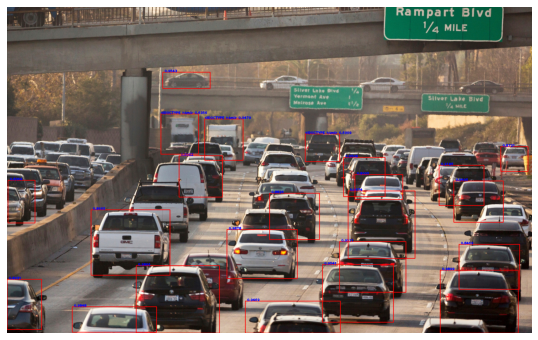

In [30]:
plt.figure(figsize=(10, 6))
_ = plt.imshow(img)
_ = plt.axis("off")

And, that's it. Using the convenient `config` file to define the model, and a set of pre-trained weights, we can very quickly start running inferences on images containing objects matching the ones in the pre-training process. For running inference on specific images, we'll need to retrain (maybe using Transfer Learning) some/all of the model's weights.

## References

- https://www.mathworks.com/discovery/object-detection.html
- https://machinelearningspace.com/yolov3-tensorflow-2-part-4/
- https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/